In [1]:
from warnings import simplefilter
from tqdm import TqdmWarning

simplefilter("ignore", UserWarning)
simplefilter("ignore", TqdmWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import rmse, mae, mase, quantile_loss, mqloss

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)

from scipy.stats import norm
import random
from functools import partial

from fpppy.models import LinearRegression
from fpppy.utils import plot_series

from utils import *

plt.style.use("ggplot")
import matplotlib as mpl
from cycler import cycler

mpl.rcParams["axes.prop_cycle"] = cycler(color=mpl.cm.tab10(range(10)))


simplefilter("ignore", category=pd.errors.PerformanceWarning)
pd.set_option("display.precision", 3)

# Table of contents
1. [A tidy forecasting workflow](#a-tidy-forecasting-workflow)
2. [Some simple forecasting methods](#some-simple-forecasting-methods)
3. [Fitted values and residuals](#fitted-values-and-residuals)
4. [Residual diagnostics](#residual-diagnostics)
5. [Distributional forecasts and prediction intervals](#distributional-forecasts-and-prediction-intervals)
6. [Forecasting using transformations](#forecasting-using-transformations)
7. [Forecasting with decomposition](#forecasting-with-decomposition)
8. [Evaluating point forecast accuracy](#evaluating-point-forecast-accuracy)
9. [Evaluating distributional forecast accuracy](#evaluation-distributional-forecast-accuracy)
10. [Time series cross-validation](#time-series-cross-validation)
11. [Exercises](#exercises)

# [A tidy forecasting workflow](https://otexts.com/fpppy/nbs/05-toolbox.html#a-tidy-forecasting-workflow)

In [2]:
gdp_df = pd.read_csv("data/global_economy.csv", parse_dates=["ds"])
gdp_df[["GDP", "Population"]] = gdp_df[["GDP", "Population"]].interpolate()
gdp_df["y"] = gdp_df["GDP"] / gdp_df["Population"]
gdp_df.drop(["Code", "Growth", "CPI", "Imports", "Exports"], axis=1, inplace=True)
gdp_df.head()

,unique_id,ds,GDP,Population,y
0,Afghanistan,1960-01-01,5.378e+08,8.996e+06,59.777
1,Afghanistan,1961-01-01,5.489e+08,9.167e+06,59.878
2,Afghanistan,1962-01-01,5.467e+08,9.346e+06,58.493
3,Afghanistan,1963-01-01,7.511e+08,9.534e+06,78.783
4,Afghanistan,1964-01-01,8.000e+08,9.731e+06,82.208


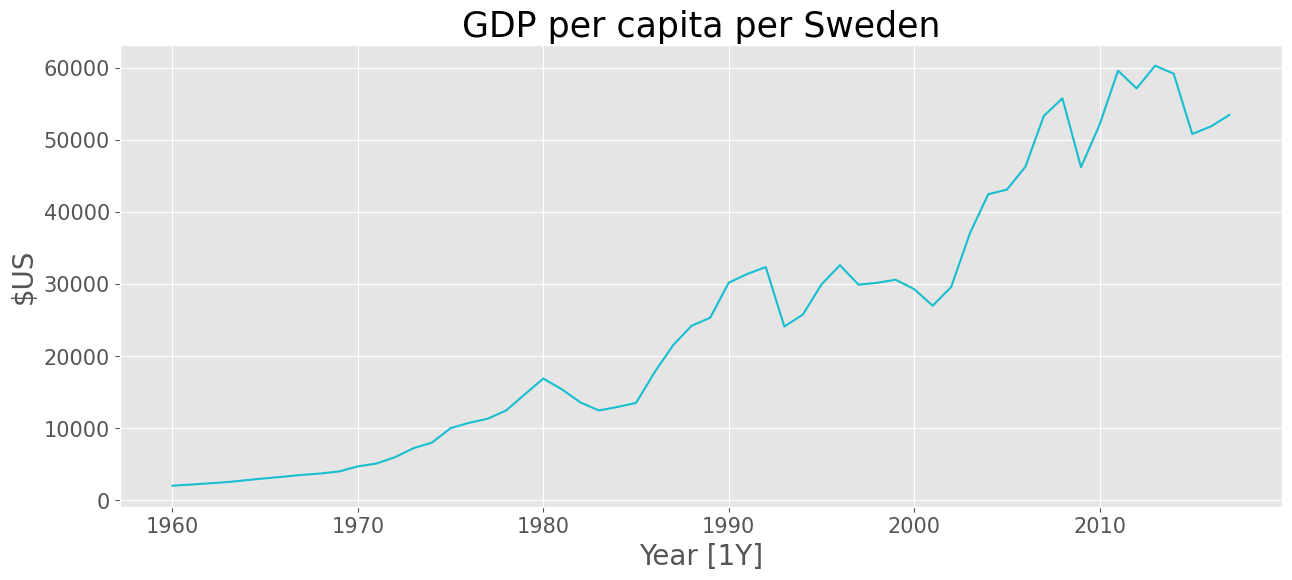

In [3]:
plot_series(
    df=gdp_df,
    id_col="unique_id",
    ids=["Sweden"],
    time_col="ds",
    target_col="y",
    xlabel="Year [1Y]",
    ylabel="$US",
    title="GDP per capita per Sweden",
)

In [4]:
train_df = gdp_df.copy()
train_df.drop(["GDP", "Population"], axis=1, inplace=True)
sweden_df = train_df[train_df["unique_id"] == "Sweden"]

In [5]:
train_features, valid_features = pipeline(
    sweden_df,
    features=[
        trend,
    ],
    freq="YS",
    h=3,
)
sf = StatsForecast(
    models=[
        SklearnModel(LinearRegression()),
    ],
    freq="YS",
)

In [6]:
sweden_df.head()

,unique_id,ds,y
13324,Sweden,1960-01-01,1983.107
13325,Sweden,1961-01-01,2147.229
13326,Sweden,1962-01-01,2315.847
13327,Sweden,1963-01-01,2492.545
13328,Sweden,1964-01-01,2758.943


In [7]:
sweden_df.tail()

,unique_id,ds,y
13377,Sweden,2013-01-01,60283.245
13378,Sweden,2014-01-01,59180.199
13379,Sweden,2015-01-01,50812.191
13380,Sweden,2016-01-01,51844.761
13381,Sweden,2017-01-01,53442.008


In [8]:
train_features.head()

,unique_id,ds,y,trend
13324,Sweden,1960-01-01,1983.107,1.0
13325,Sweden,1961-01-01,2147.229,2.0
13326,Sweden,1962-01-01,2315.847,3.0
13327,Sweden,1963-01-01,2492.545,4.0
13328,Sweden,1964-01-01,2758.943,5.0


In [9]:
valid_features.head()

,unique_id,ds,trend
0,Sweden,2018-01-01,59.0
1,Sweden,2019-01-01,60.0
2,Sweden,2020-01-01,61.0


In [10]:
import inspect

print(inspect.getsource(LinearRegression))

class LinearRegression(_LinearRegression):
    def fit(self, X, y, sample_weight=None):
        result = super().fit(X, y, sample_weight)
        self._X = X
        self._y = y
        self._residuals = y - self.predict(X)
        self._n, self._p = X.shape
        X_to_stack = (
            X.values.astype(float) if isinstance(X, pd.DataFrame) else X.astype(float)
        )
        self._X_design = np.hstack([np.ones((self._n, 1)), X_to_stack])
        self._mse = np.sum(self._residuals**2) / (self._n - self._p - 1)
        self._se = np.sqrt(self._mse)
        self._var_names = (
            list(X.columns)
            if hasattr(X, "columns")
            else [f"x{i}" for i in range(1, self._p + 1)]
        )
        return result

    def add_prediction_intervals(
        self, forecast_df: pd.DataFrame, new_X: pd.DataFrame
    ) -> pd.DataFrame:
        if not all(name in new_X.columns for name in self._var_names):
            raise ValueError(
                "new_X must contain

In [11]:
sf.fit(df=train_features)
fcasts = sf.predict(
    h=3,
    X_df=valid_features,
)
fcasts = (
    sf.fitted_[0][0]
    .model_["model"]
    .add_prediction_intervals(fcasts, valid_features.rename(columns={"trend": "x1"}))
)

In [12]:
fcasts

,unique_id,ds,LinearRegression,LinearRegression-lo-95,LinearRegression-hi-95,LinearRegression-lo-80,LinearRegression-hi-80
0,Sweden,2018-01-01,56165.506,46066.615,66264.397,49570.311,62760.700
1,Sweden,2019-01-01,57225.849,47109.566,67342.132,50619.297,63832.401
2,Sweden,2020-01-01,58286.193,48151.970,68420.416,51667.925,64904.461


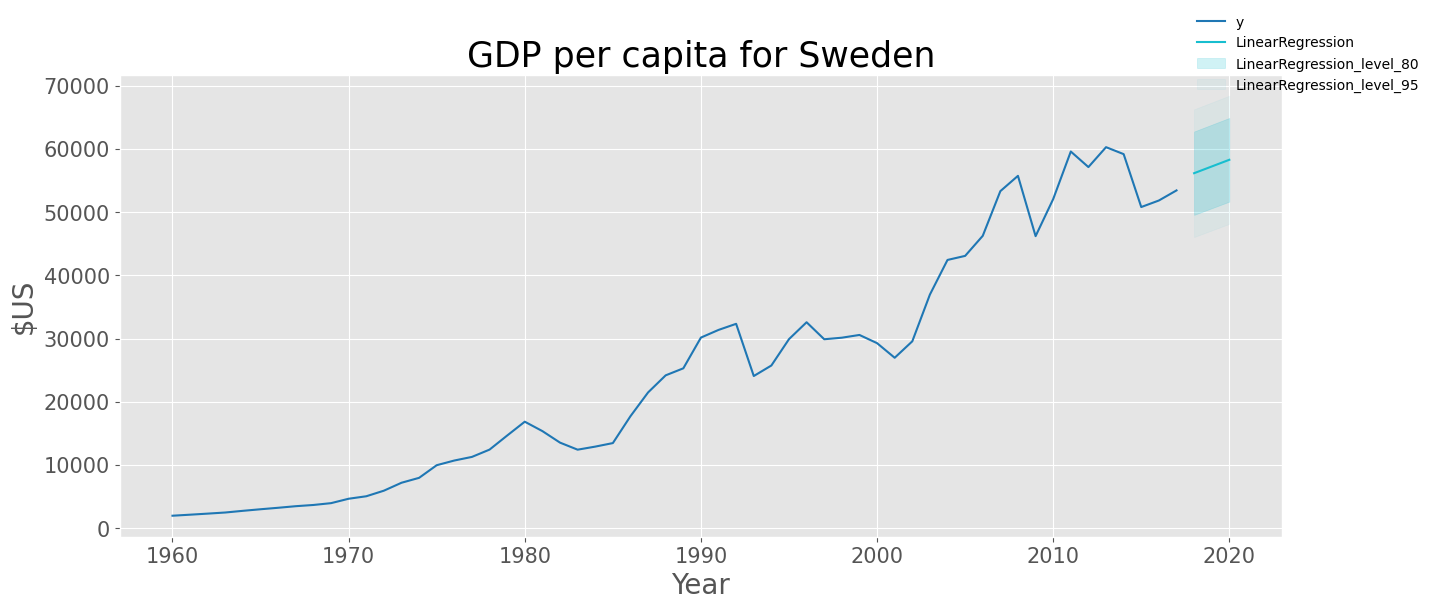

In [13]:
plot_series(
    train_df,
    fcasts,
    level=[80, 95],
    ids=["Sweden"],
    xlabel="Year",
    ylabel="$US",
    title="GDP per capita for Sweden",
    rm_legend=False,
)

# [Some simple forecasting methods](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-simple-methods)

In [14]:
production_df = pd.read_csv("data/aus_production_formatted.csv", parse_dates=["ds"])
production_df.head()

,unique_id,ds,y
0,Beer,1956-03-01,284.0
1,Beer,1956-06-01,213.0
2,Beer,1956-09-01,227.0
3,Beer,1956-12-01,308.0
4,Beer,1957-03-01,262.0


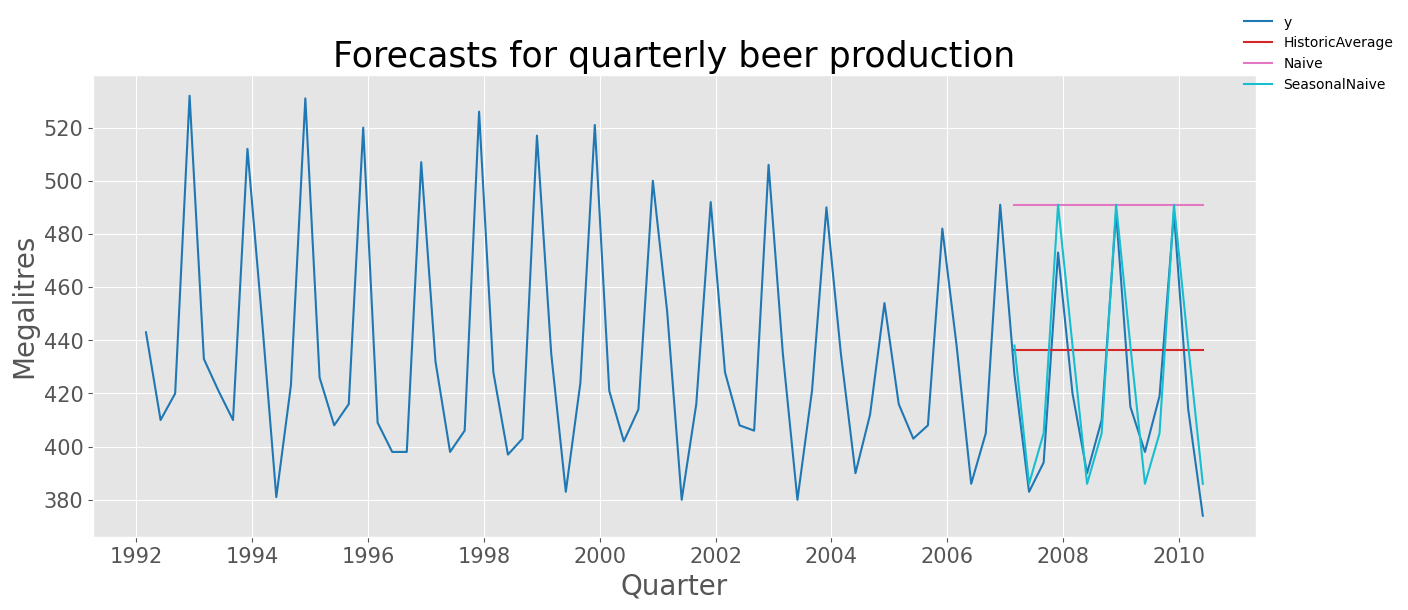

In [15]:
beers_df = production_df[
    (production_df["unique_id"] == "Beer") & (production_df["ds"] >= "1992-01-01")
]

train = beers_df[:-14]
test = beers_df[-14:]

avg_method = HistoricAverage()
naive_method = Naive()
seasonal_naive_method = SeasonalNaive(4)

sf = StatsForecast(
    models=[avg_method, naive_method, seasonal_naive_method],
    freq=pd.offsets.QuarterBegin(1),
)

sf.fit(train)

fcasts = sf.predict(h=14)
fcasts["y"] = test["y"].values

plot_series(
    train,
    fcasts,
    xlabel="Quarter",
    ylabel="Megalitres",
    title="Forecasts for quarterly beer production",
    rm_legend=False,
)

In [16]:
gafa_df = pd.read_csv("data/gafa_stock.csv", parse_dates=["ds"])
goog_df = gafa_df[
    (gafa_df["unique_id"] == "GOOG_Close")
    & (gafa_df["ds"] >= "2015-01-01")
    & (gafa_df["ds"] <= "2016-01-31")
].copy()

train = goog_df[goog_df["ds"].dt.year == 2015].copy()
test = goog_df[goog_df["ds"].dt.year == 2016].copy()

train["ds"] = np.arange(len(train))
test["ds"] = np.arange(len(test))

print(len(train), len(test))

252 19


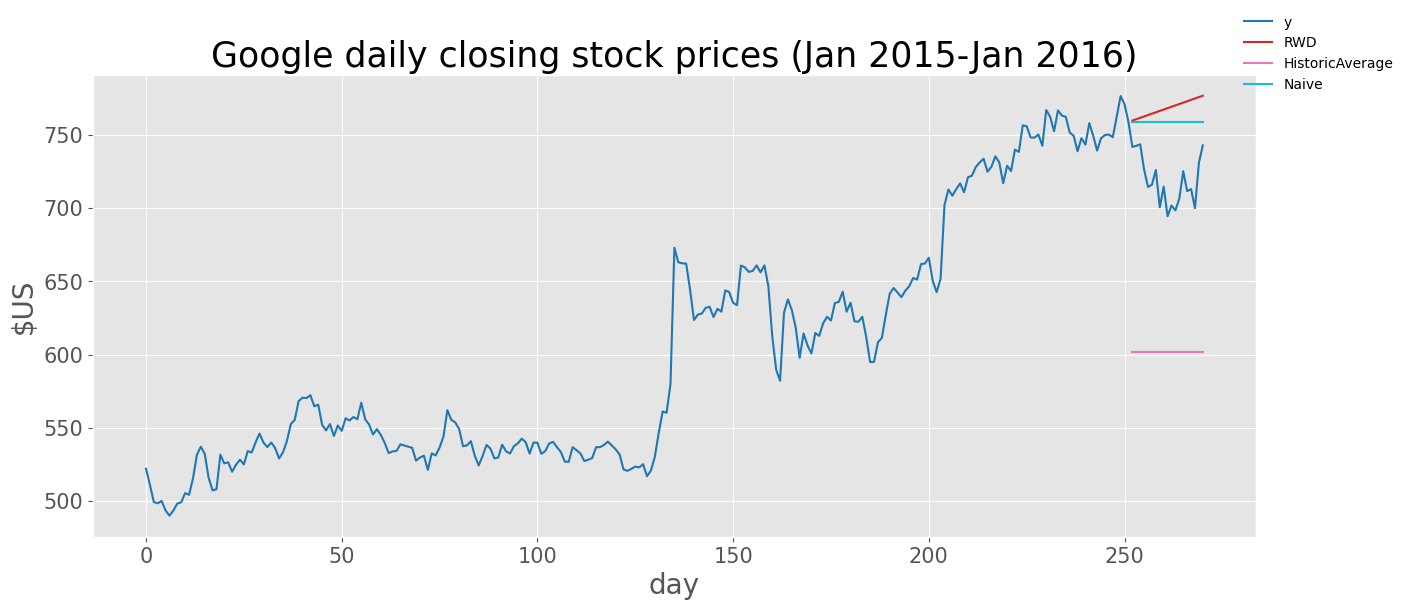

In [17]:
avg_method = HistoricAverage()
naive_method = Naive()
drift_method = RandomWalkWithDrift()
sf = StatsForecast(models=[drift_method, avg_method, naive_method], freq=1)
sf.fit(train)

fcasts = sf.predict(h=len(test))
fcasts["y"] = test["y"].values

plot_series(
    train,
    fcasts,
    xlabel="day",
    ylabel="$US",
    title="Google daily closing stock prices (Jan 2015-Jan 2016)",
    rm_legend=False,
)

# [Fitted values and residuals](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-residuals)

In [18]:
train = beers_df[:-14].copy()
test = beers_df[-14:].copy()

mean_method = HistoricAverage()
sf = StatsForecast(models=[mean_method], freq="QE")
sf.forecast(h=14, df=train, fitted=True)
fitted_values = sf.forecast_fitted_values()
train["fitted"] = fitted_values["HistoricAverage"].values
train["resid"] = train["y"] - train["fitted"]
train["innov"] = train["y"] - train["fitted"]
train.head()

,unique_id,ds,y,fitted,resid,innov
144,Beer,1992-03-01,443.0,436.45,6.55,6.55
145,Beer,1992-06-01,410.0,436.45,-26.45,-26.45
146,Beer,1992-09-01,420.0,436.45,-16.45,-16.45
147,Beer,1992-12-01,532.0,436.45,95.55,95.55
148,Beer,1993-03-01,433.0,436.45,-3.45,-3.45


If patterns are observable in the residuals/innovation residuals, the model can probably be improved.

# [Residual diagnostics](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-diagnostics)

Good forecasting method:
- innovation residuals are uncorrelated; otherwise, there is information left in the residuals than should be used.
- innovation residuals have zero mean; if they have a mean other than zero, the forecasts are biased.

That does not mean a forecasting method satisfying these properties cannot be improved though.

Adjusting for bias is easy: if $m$ is the mean of the residuals, add $m$ to all the forecasts.

It is useful for the residuals to:
- have constant variance (homoscedasticity)
- be normally distributed

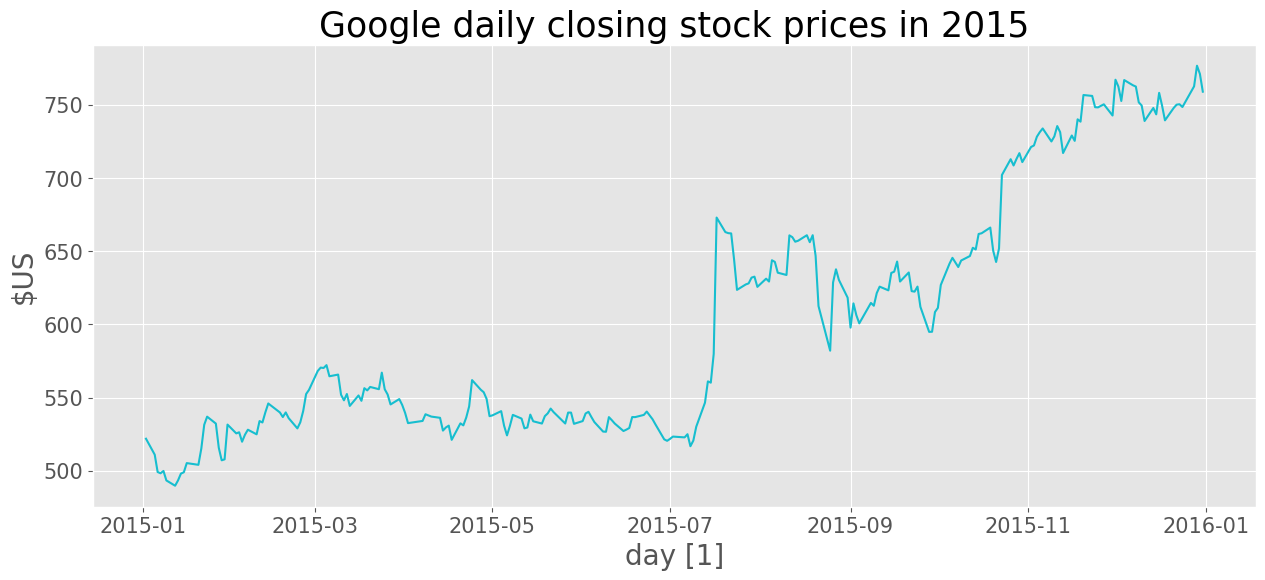

In [19]:
train = goog_df[goog_df["ds"].dt.year == 2015].copy()
plot_series(
    train,
    xlabel="day [1]",
    ylabel="$US",
    title="Google daily closing stock prices in 2015",
)

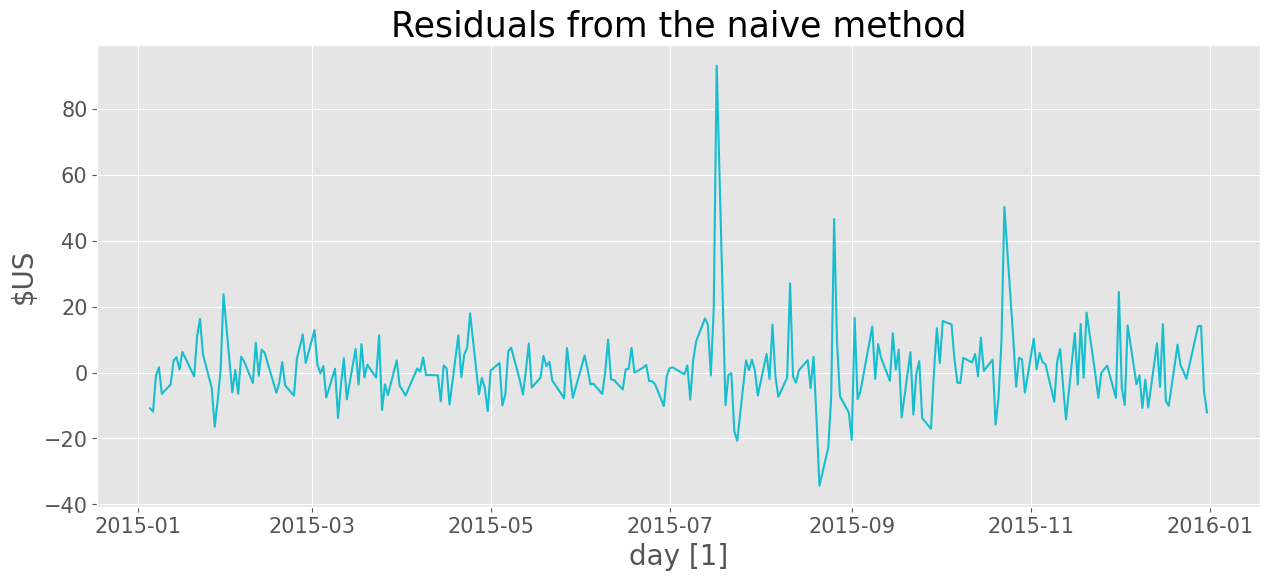

In [20]:
train["resid"] = train["y"].diff().values
plot_series(
    train,
    target_col="resid",
    xlabel="day [1]",
    ylabel="$US",
    title="Residuals from the naive method",
)

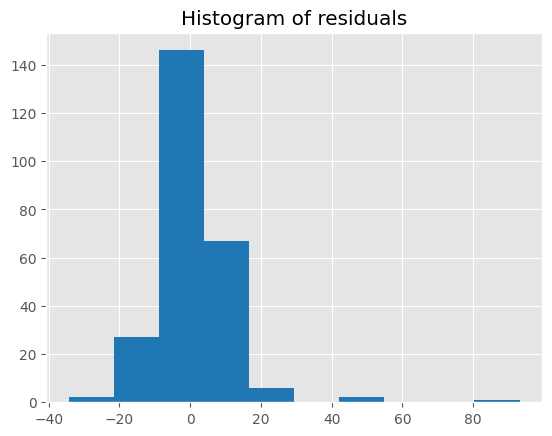

In [21]:
ax = train["resid"].hist()
ax.set_title("Histogram of residuals")
plt.show()

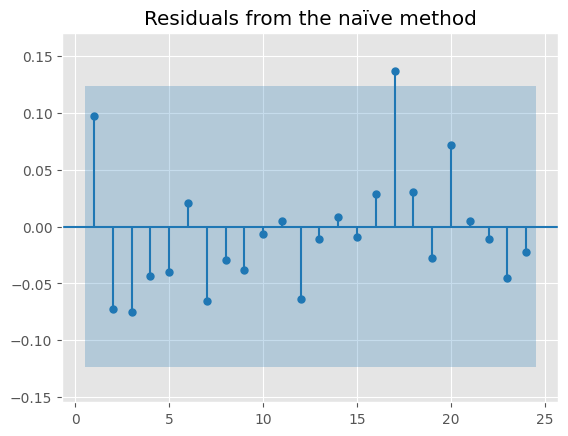

In [22]:
fig = plot_acf(
    train["resid"][1:],
    zero=False,
    auto_ylims=True,
    bartlett_confint=False,
    title="Residuals from the naïve method",
)

- Mean of residuals is close to zero, no significant correlation in the residuals series.
- Apart from one outlier, time plot of the residuals shows the variation of the residuals stays the same, so the residual variance can be treated as constant.
- Histogram shows the distribution might not be normal, with the right tail being a bit long, so prediction intervals computed assuming a normal distribution may be inaccurate.

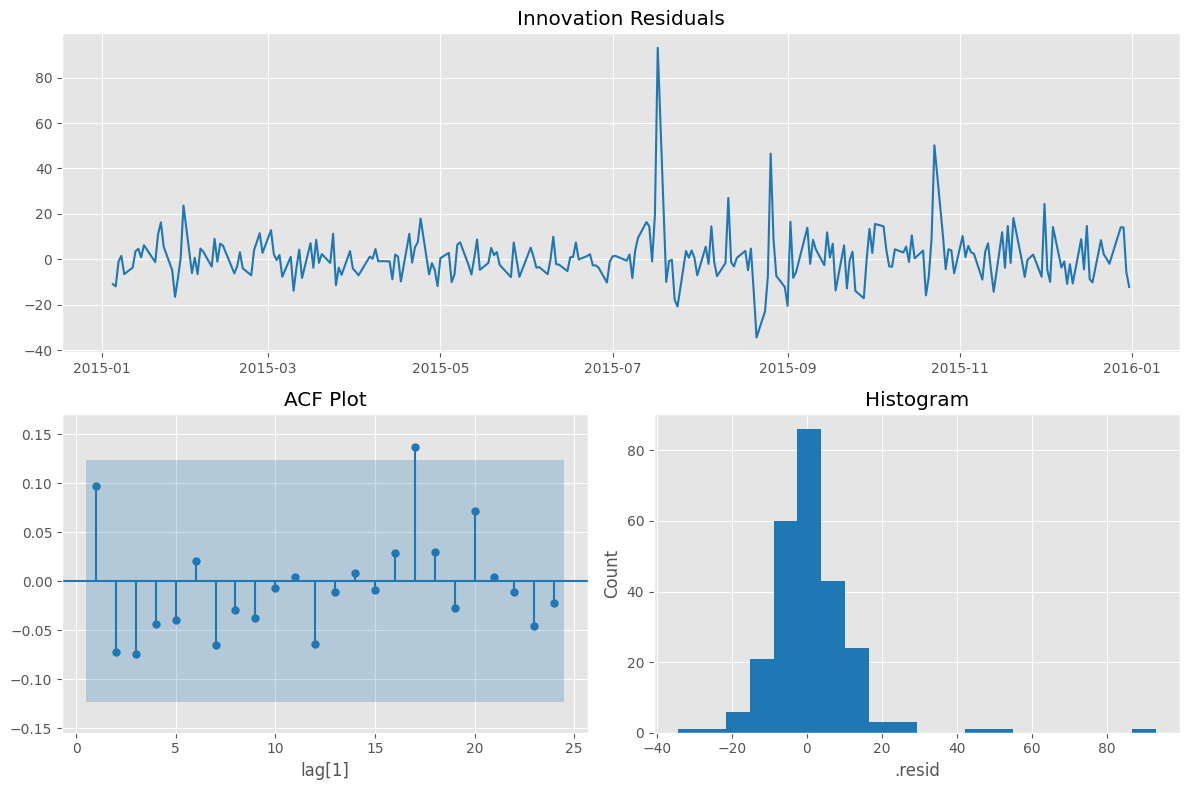

In [23]:
plot_diagnostics(train)

### Portmanteau tests for autocorrelation

In [24]:
resid_test = acorr_ljungbox(train["resid"].dropna(), boxpierce=True)
resid_test

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.417,0.120,2.389,0.122
2,3.761,0.153,3.711,0.156
3,5.193,0.158,5.115,0.164
4,5.675,0.225,5.585,0.232
5,6.084,0.298,5.983,0.308
6,6.195,0.402,6.090,0.413
7,7.303,0.398,7.159,0.413
8,7.525,0.481,7.372,0.497
9,7.902,0.544,7.733,0.561
10,7.914,0.637,7.745,0.654


In [25]:
train = goog_df[goog_df["ds"].dt.year == 2015].copy()
drift_method = RandomWalkWithDrift()
sf = StatsForecast(models=[drift_method], freq="B")
sf.fit(train)
fcasts = sf.forecast(df=train, h=10, fitted=True)
insample_preds = sf.forecast_fitted_values()
insample_preds["resid"] = insample_preds["y"] - insample_preds["RWD"]
insample_preds

,unique_id,ds,y,RWD,resid
0,GOOG_Close,2015-01-02,521.938,NaN,NaN
1,GOOG_Close,2015-01-05,511.058,522.882,-11.824
2,GOOG_Close,2015-01-06,499.213,512.002,-12.789
3,GOOG_Close,2015-01-07,498.358,500.157,-1.799
4,GOOG_Close,2015-01-08,499.929,499.302,0.627
...,...,...,...,...,...
247,GOOG_Close,2015-12-24,748.400,751.254,-2.854
248,GOOG_Close,2015-12-28,762.510,749.344,13.166
249,GOOG_Close,2015-12-29,776.600,763.454,13.146
250,GOOG_Close,2015-12-30,771.000,777.544,-6.544


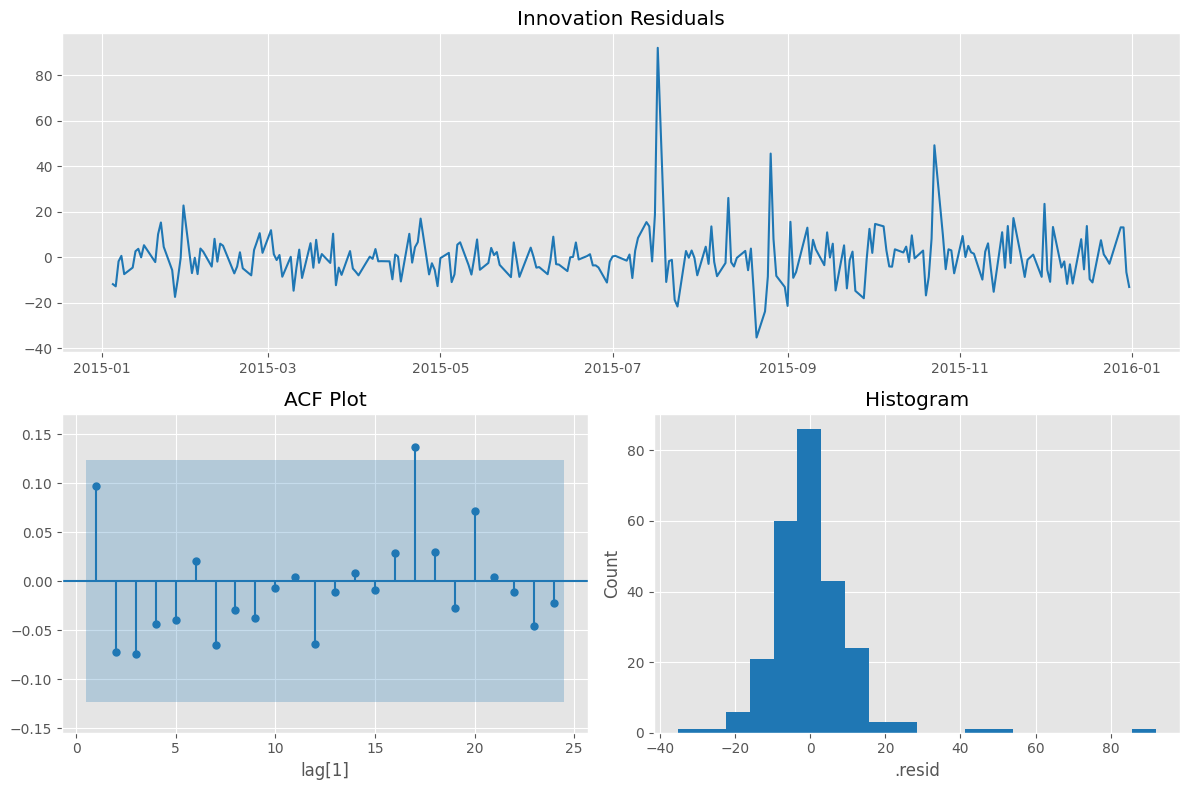

In [26]:
plot_diagnostics(insample_preds)

In [27]:
resid_test = acorr_ljungbox(insample_preds["resid"].dropna(), boxpierce=True)
resid_test

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.417,0.120,2.389,0.122
2,3.761,0.153,3.711,0.156
3,5.193,0.158,5.115,0.164
4,5.675,0.225,5.585,0.232
5,6.084,0.298,5.983,0.308
6,6.195,0.402,6.090,0.413
7,7.303,0.398,7.159,0.413
8,7.525,0.481,7.372,0.497
9,7.902,0.544,7.733,0.561
10,7.914,0.637,7.745,0.654


# [Distributional forecasts and prediction intervals](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-prediction-intervals)

### Example of standard deviation of the forecast distribution for one-step prediction intervals using the naive method

In [28]:
train = goog_df[goog_df["ds"].dt.year == 2015].copy()
drift_method = Naive()
sf = StatsForecast(models=[drift_method], freq="B")
sf.fit(train)
fcasts = sf.forecast(df=train, h=10, fitted=True)
insample_preds = sf.forecast_fitted_values()
insample_preds["resid"] = insample_preds["y"] - insample_preds["Naive"]
insample_preds

,unique_id,ds,y,Naive,resid
0,GOOG_Close,2015-01-02,521.938,NaN,NaN
1,GOOG_Close,2015-01-05,511.058,521.938,-10.880
2,GOOG_Close,2015-01-06,499.213,511.058,-11.845
3,GOOG_Close,2015-01-07,498.358,499.213,-0.855
4,GOOG_Close,2015-01-08,499.929,498.358,1.571
...,...,...,...,...,...
247,GOOG_Close,2015-12-24,748.400,750.310,-1.910
248,GOOG_Close,2015-12-28,762.510,748.400,14.110
249,GOOG_Close,2015-12-29,776.600,762.510,14.090
250,GOOG_Close,2015-12-30,771.000,776.600,-5.600


In [29]:
K = 0
M = 1
se = np.sqrt(
    np.sum(np.square(insample_preds.dropna()["resid"])) / (len(insample_preds) - K - M)
)
se

np.float64(11.189583282095542)

In [30]:
train = goog_df[goog_df["ds"].dt.year == 2015].copy()
naive_method = Naive()
sf = StatsForecast(models=[naive_method], freq="B")
fcasts = sf.forecast(df=train, h=10, level=[80, 95])
fcasts

,unique_id,ds,Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
0,GOOG_Close,2016-01-01,758.88,744.540,736.949,773.220,780.811
1,GOOG_Close,2016-01-04,758.88,738.600,727.865,779.160,789.895
2,GOOG_Close,2016-01-05,758.88,734.042,720.894,783.718,796.866
3,GOOG_Close,2016-01-06,758.88,730.200,715.018,787.560,802.742
4,GOOG_Close,2016-01-07,758.88,726.815,709.840,790.945,807.920
5,GOOG_Close,2016-01-08,758.88,723.754,705.160,794.006,812.600
6,GOOG_Close,2016-01-11,758.88,720.940,700.856,796.820,816.904
7,GOOG_Close,2016-01-12,758.88,718.320,696.849,799.440,820.911
8,GOOG_Close,2016-01-13,758.88,715.860,693.086,801.900,824.674
9,GOOG_Close,2016-01-14,758.88,713.533,689.528,804.227,828.232


In [31]:
q80 = norm.ppf(q=0.90)
q95 = norm.ppf(q=0.975)
for i, row in fcasts.iterrows():
    value = row["Naive"]
    h = i + 1
    print(
        f"Naive-lo-80: {value-q80*se*np.sqrt(h):0.3f} | Naive-lo-95: {value-q95*se*np.sqrt(h):0.3f} | Naive-hi-80: {value+q80*se*np.sqrt(h):0.3f} | Naive-hi-95: {value+q95*se*np.sqrt(h):0.3f}"
    )

Naive-lo-80: 744.540 | Naive-lo-95: 736.949 | Naive-hi-80: 773.220 | Naive-hi-95: 780.811
Naive-lo-80: 738.600 | Naive-lo-95: 727.865 | Naive-hi-80: 779.160 | Naive-hi-95: 789.895
Naive-lo-80: 734.042 | Naive-lo-95: 720.894 | Naive-hi-80: 783.718 | Naive-hi-95: 796.866
Naive-lo-80: 730.200 | Naive-lo-95: 715.018 | Naive-hi-80: 787.560 | Naive-hi-95: 802.742
Naive-lo-80: 726.815 | Naive-lo-95: 709.840 | Naive-hi-80: 790.945 | Naive-hi-95: 807.920
Naive-lo-80: 723.754 | Naive-lo-95: 705.160 | Naive-hi-80: 794.006 | Naive-hi-95: 812.600
Naive-lo-80: 720.940 | Naive-lo-95: 700.856 | Naive-hi-80: 796.820 | Naive-hi-95: 816.904
Naive-lo-80: 718.320 | Naive-lo-95: 696.849 | Naive-hi-80: 799.440 | Naive-hi-95: 820.911
Naive-lo-80: 715.860 | Naive-lo-95: 693.086 | Naive-hi-80: 801.900 | Naive-hi-95: 824.674
Naive-lo-80: 713.533 | Naive-lo-95: 689.528 | Naive-hi-80: 804.227 | Naive-hi-95: 828.232


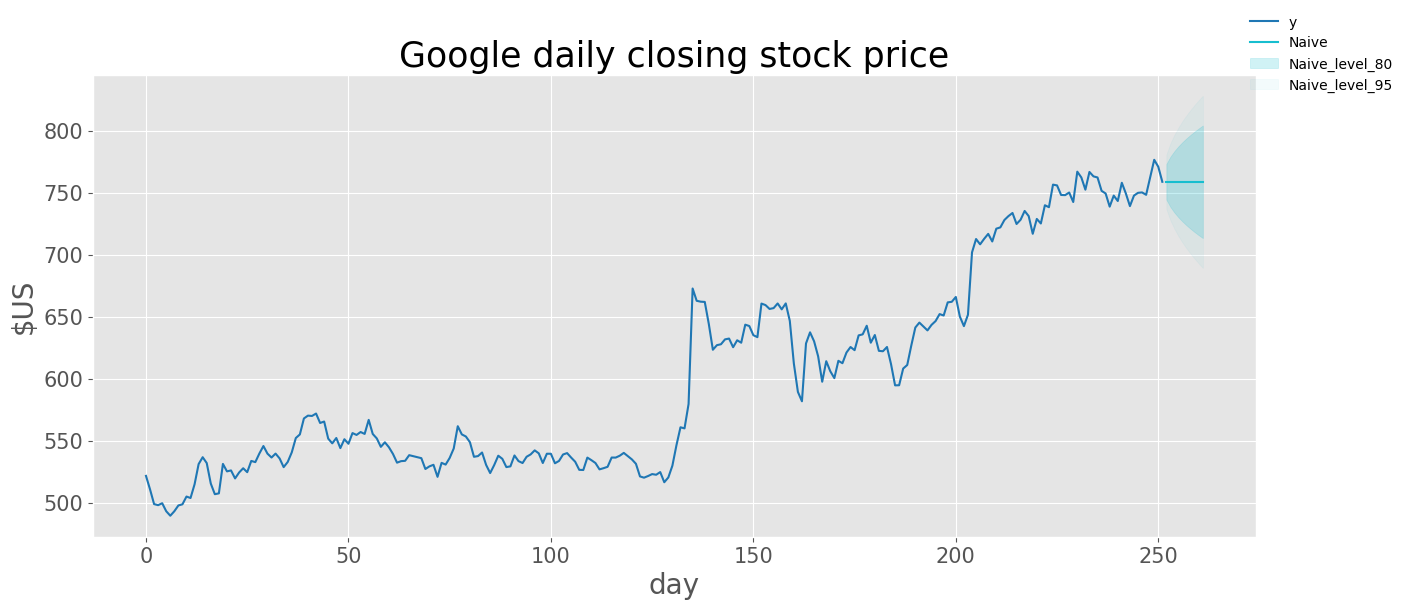

In [32]:
train["ds"] = np.arange(len(train))
fcasts["ds"] = train["ds"].max() + np.arange(start=1, stop=len(fcasts) + 1)
plot_series(
    train,
    fcasts,
    level=[80, 95],
    xlabel="day",
    ylabel="$US",
    title="Google daily closing stock price",
    rm_legend=False,
)

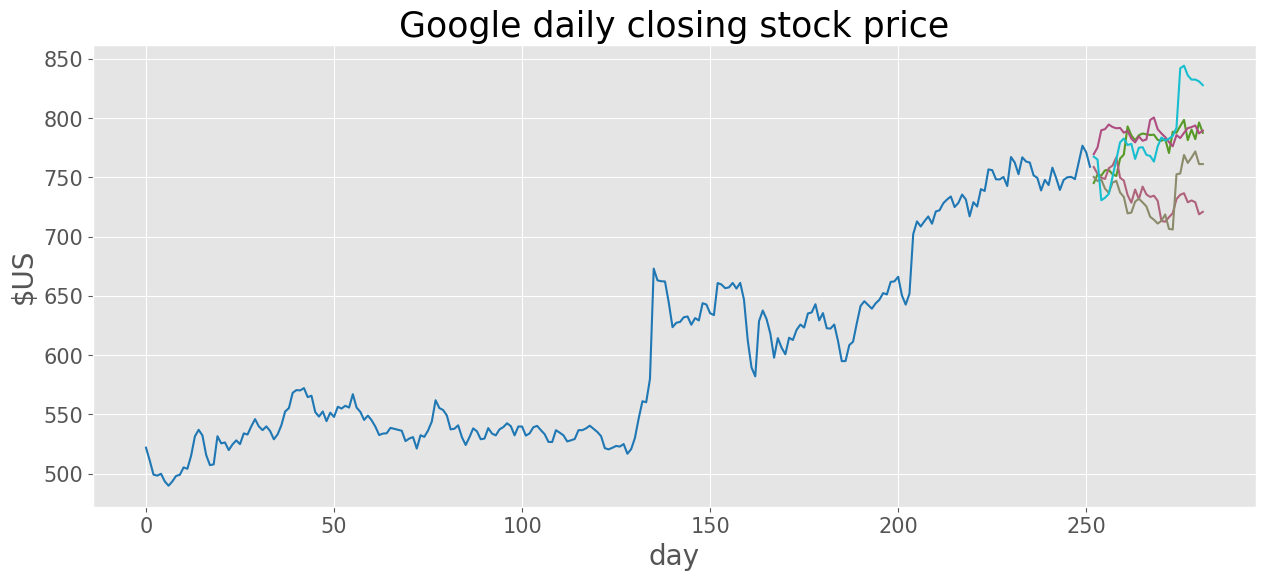

In [33]:
sf = StatsForecast(models=[Naive()], freq=1)
fc = sf.forecast(df=train, h=1, fitted=True)
fitted = sf.forecast_fitted_values()
errors = fitted["y"] - fitted["Naive"]
errors = errors[1:].to_list()  # first value is NaN
last_obs = train.iloc[-1, -1]

num_sims = 5000
sim = np.zeros((30, num_sims))

for j in range(num_sims):
    e = random.sample(errors, 1).pop()
    yhat = last_obs + e

    sim[0, j] = yhat

    for i in range(1, 30):
        e = random.sample(errors, 1).pop()
        sim[i, j] = sim[i - 1, j] + e

sim_df = pd.DataFrame(sim)
sim_df.columns = [f"sim_{i}" for i in range(num_sims)]
sim_df["unique_id"] = "GOOG_Close"
sim_df["ds"] = train["ds"].max() + np.arange(start=1, stop=len(sim_df) + 1)
plot_series(
    train,
    sim_df,
    models=["sim_0", "sim_1", "sim_2", "sim_3", "sim_4"],
    xlabel="day",
    ylabel="$US",
    title="Google daily closing stock price",
)

In [34]:
sim_df.head()

,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,...,sim_4992,sim_4993,sim_4994,sim_4995,sim_4996,sim_4997,sim_4998,sim_4999,unique_id,ds
0,745.116,769.460,758.612,750.220,767.34,753.75,758.55,757.330,751.277,751.090,...,741.80,759.134,748.760,766.40,751.21,759.540,760.010,809.090,GOOG_Close,252
1,752.266,775.090,753.012,746.850,764.94,758.81,762.30,772.020,751.008,753.250,...,725.98,772.003,746.850,745.68,750.33,760.200,759.290,808.255,GOOG_Close,253
2,751.386,789.640,749.642,748.078,730.59,756.20,759.69,759.270,753.238,755.760,...,728.14,767.453,743.255,722.81,750.91,752.597,762.900,808.715,GOOG_Close,254
3,755.846,790.555,748.542,740.378,732.70,758.43,756.09,758.940,757.088,756.516,...,723.01,766.488,739.085,723.47,744.41,766.557,767.564,810.275,GOOG_Close,255
4,756.100,794.485,757.602,736.778,735.94,785.48,763.01,752.933,746.498,753.393,...,722.00,757.905,731.855,709.82,739.28,765.547,757.444,814.205,GOOG_Close,256


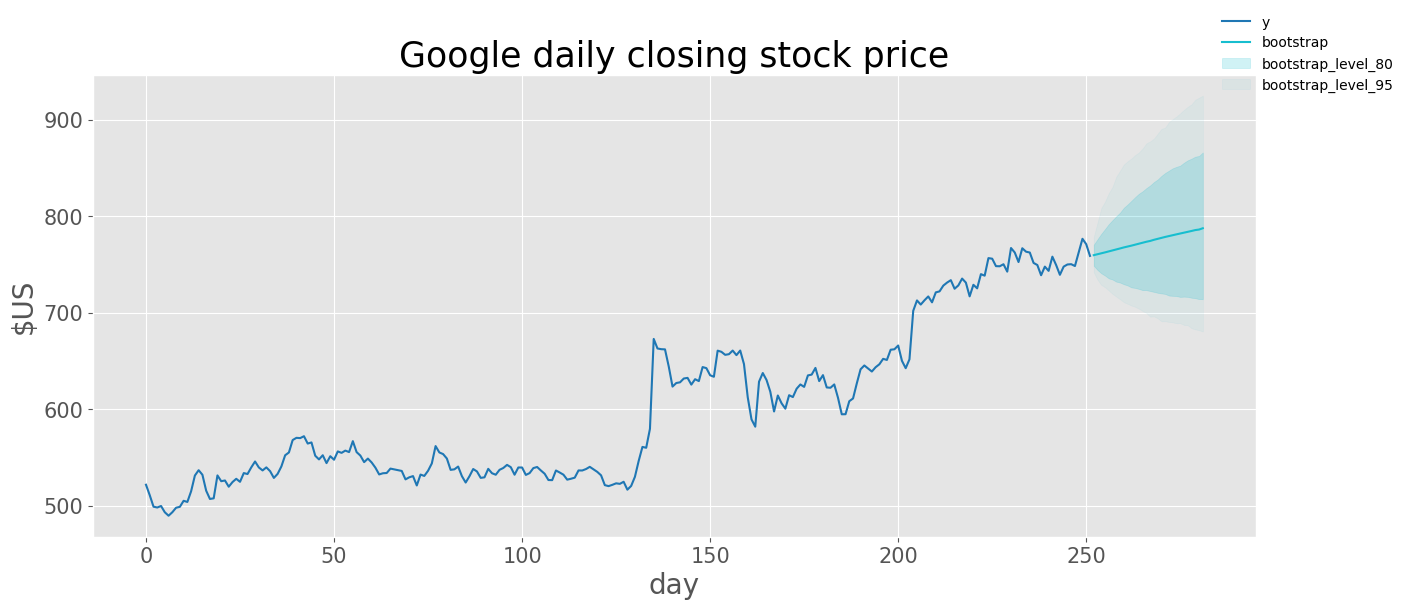

In [35]:
sim_df["bootstrap"] = sim_df.drop(["unique_id", "ds"], axis=1).mean(axis=1)
sim_df["bootstrap-lo-80"] = sim_df.drop(["unique_id", "ds"], axis=1).quantile(
    0.1, axis=1
)
sim_df["bootstrap-hi-80"] = sim_df.drop(["unique_id", "ds"], axis=1).quantile(
    0.9, axis=1
)
sim_df["bootstrap-lo-95"] = sim_df.drop(["unique_id", "ds"], axis=1).quantile(
    0.025, axis=1
)
sim_df["bootstrap-hi-95"] = sim_df.drop(["unique_id", "ds"], axis=1).quantile(
    0.975, axis=1
)

plot_series(
    train,
    sim_df,
    models=["bootstrap"],
    level=[80, 95],
    xlabel="day",
    ylabel="$US",
    title="Google daily closing stock price",
    rm_legend=False,
)

# [Forecasting using transformations](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-ftransformations)

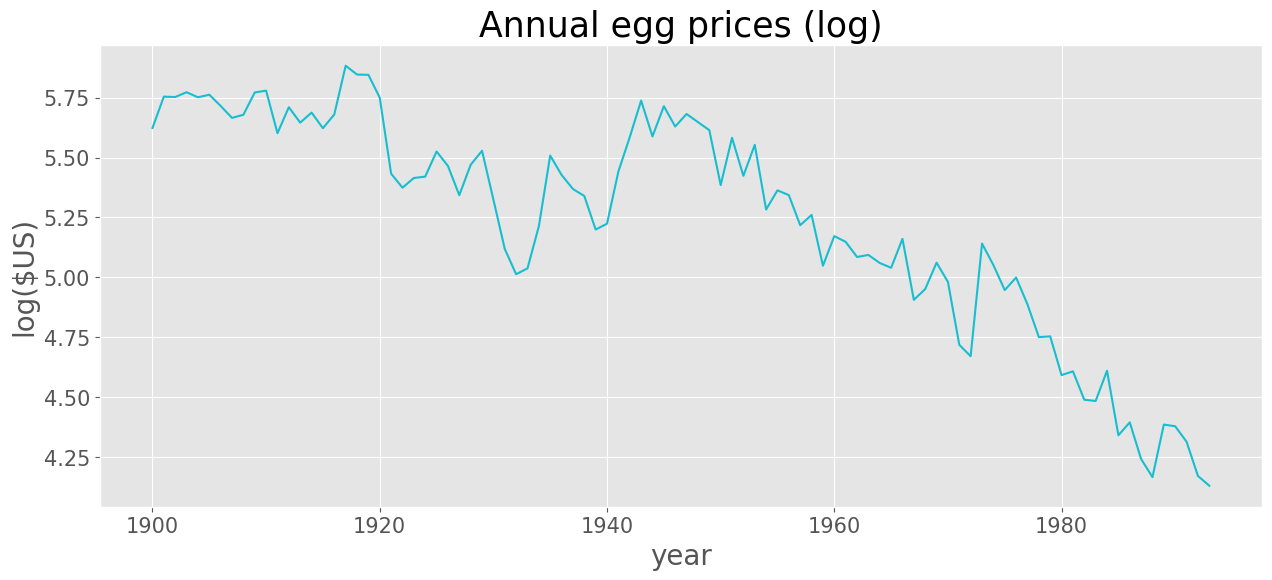

In [36]:
egg_df = pd.read_csv("data/eggs.csv", parse_dates=["ds"])
egg_df_log = egg_df.copy()
egg_df_log["y"] = np.log(egg_df_log["y"])

plot_series(
    egg_df_log, xlabel="year", ylabel="log($US)", title="Annual egg prices (log)"
)

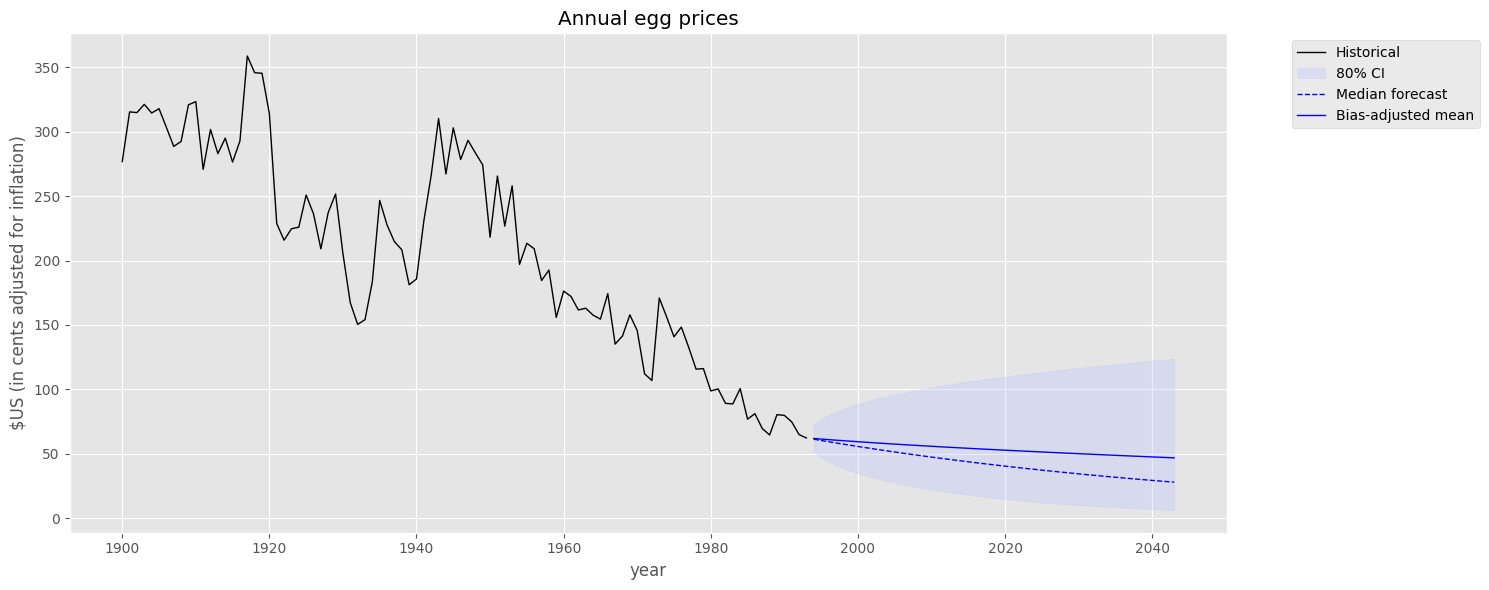

In [37]:
rwd_method = RandomWalkWithDrift()
sf = StatsForecast(models=[rwd_method], freq="YE")
sf.fit(egg_df_log)
fcasts = sf.forecast(df=egg_df_log, h=50, level=[80, 95])
sigma_h = (fcasts["RWD-hi-80"] - fcasts["RWD-lo-80"]) / (2 * 1.28)
sigma_h_squared = sigma_h**2
bias_adjusted = np.exp(fcasts["RWD"]) * (1 + sigma_h_squared / 2)
fcasts_original = fcasts.copy()
columns_to_transform = ["RWD", "RWD-lo-80", "RWD-lo-95", "RWD-hi-80", "RWD-hi-95"]
for col in columns_to_transform:
    fcasts_original[col] = np.exp(fcasts[col])
fcasts_original["RWD-adjusted"] = bias_adjusted

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(egg_df["ds"], egg_df["y"], color="black", label="Historical", linewidth=1)
ax.fill_between(
    fcasts_original["ds"],
    fcasts_original["RWD-lo-80"],
    fcasts_original["RWD-hi-80"],
    alpha=0.3,
    color="#B8BFFF",
    label="80% CI",
)
ax.plot(
    fcasts_original["ds"],
    fcasts_original["RWD"],
    color="blue",
    linestyle="--",
    label="Median forecast",
    linewidth=1,
)
ax.plot(
    fcasts_original["ds"],
    fcasts_original["RWD-adjusted"],
    color="blue",
    linestyle="-",
    label="Bias-adjusted mean",
    linewidth=1,
)
ax.set_title("Annual egg prices")
ax.set_xlabel("year")
ax.set_ylabel("$US (in cents adjusted for inflation)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# [Forecasting with decomposition](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-forecasting-decomposition)

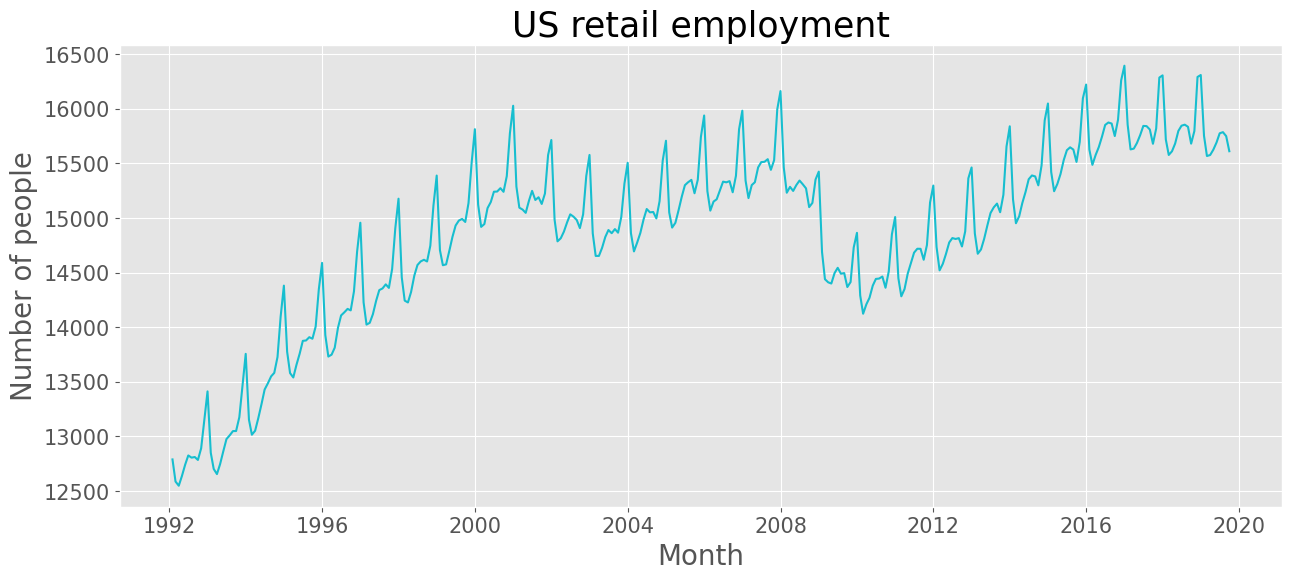

In [38]:
us_employment_df = pd.read_csv("data/us_employment_formatted.csv", parse_dates=["ds"])
us_retail_employment_df = us_employment_df[
    (us_employment_df["Title"] == "Retail Trade")
    & (us_employment_df["ds"].dt.year >= 1992)
].copy()

plot_series(
    us_retail_employment_df,
    xlabel="Month",
    ylabel="Number of people",
    title="US retail employment",
)

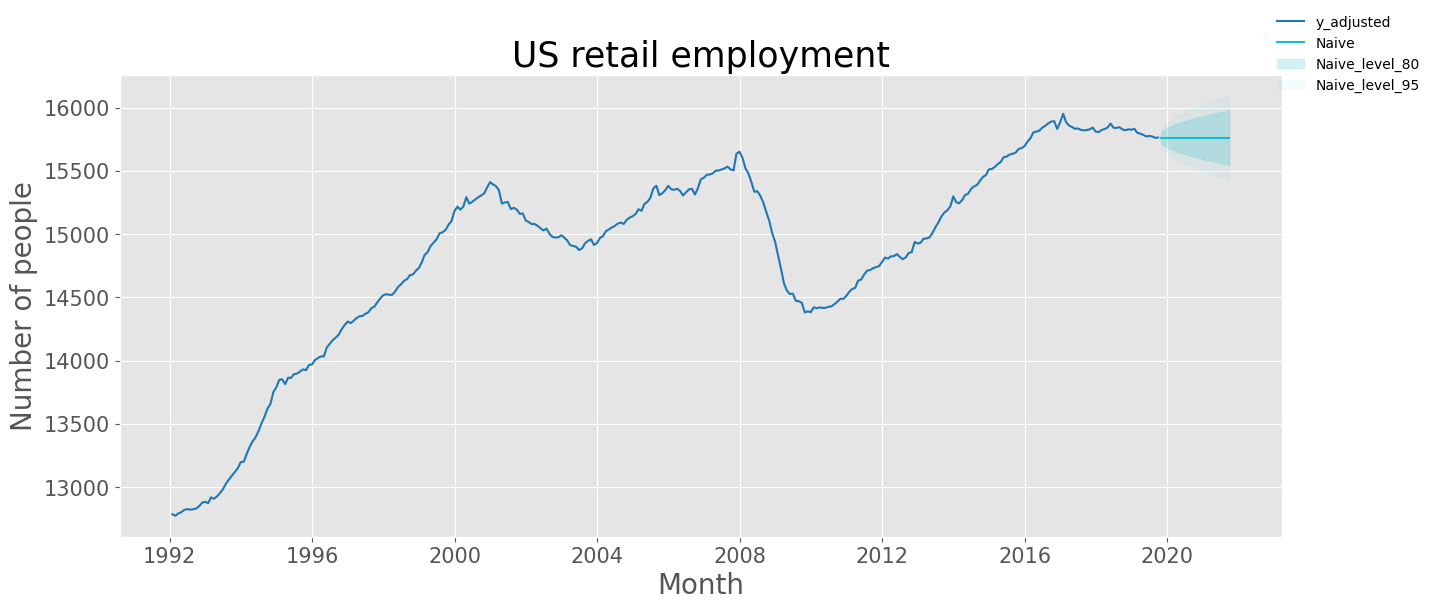

In [39]:
train_df = us_retail_employment_df.drop(["Title"], axis=1)

stl = STL(train_df["y"].values, period=12, robust=True, trend_deg=7)
res = stl.fit()

train_df["seasonal"] = res.seasonal
train_df["y_adjusted"] = train_df["y"] - train_df["seasonal"]

naive_method = Naive()
sf = StatsForecast(models=[naive_method], freq="ME")
adjusted_fcasts = sf.forecast(
    h=24, level=[80, 95], df=train_df, target_col="y_adjusted", fitted=True
)

adjusted_fcasts_fitted = sf.forecast_fitted_values()
plot_series(
    train_df,
    adjusted_fcasts,
    target_col="y_adjusted",
    level=[80, 95],
    xlabel="Month",
    ylabel="Number of people",
    title="US retail employment",
    rm_legend=False,
)

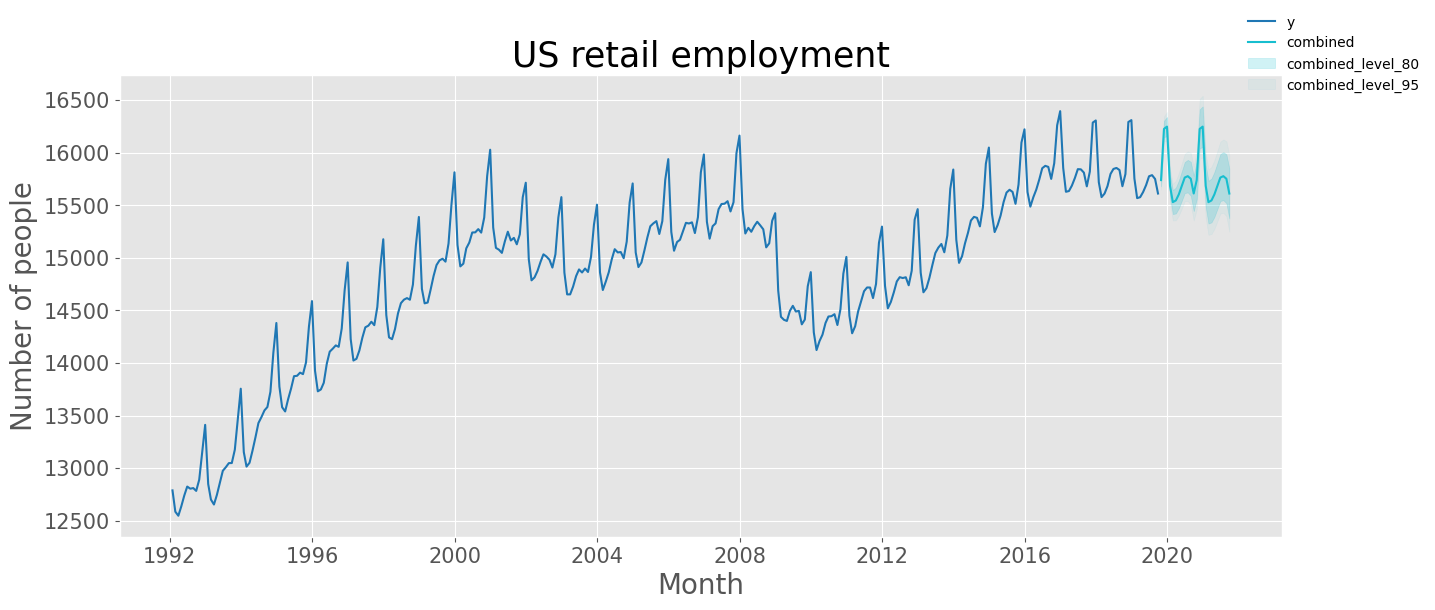

In [40]:
seasonal_naive = SeasonalNaive(12)
sf = StatsForecast(models=[seasonal_naive], freq="ME")
seasonal_fcasts = sf.forecast(
    h=24, level=[80, 95], df=train_df, target_col="seasonal", fitted=True
)
merged_df = adjusted_fcasts.merge(seasonal_fcasts, on=["unique_id", "ds"], how="inner")
merged_df_fitted = adjusted_fcasts_fitted.merge(
    sf.forecast_fitted_values(), on=["unique_id", "ds"], how="inner"
)
merged_df_fitted["combined"] = (
    merged_df_fitted["Naive"] + merged_df_fitted["SeasonalNaive"]
)
merged_df_fitted = merged_df_fitted.merge(train_df, on=["unique_id", "ds"], how="right")
final_df = merged_df[["unique_id", "ds"]].copy()  # Start with identifier columns
final_df["combined"] = merged_df["Naive"] + merged_df["SeasonalNaive"]
train_df["resid"] = (
    merged_df_fitted["y"].values
    - merged_df_fitted["Naive"].values
    - merged_df_fitted["SeasonalNaive"].values
)
final_df["combined-lo-80"] = merged_df["Naive-lo-80"] + merged_df["SeasonalNaive-lo-80"]
final_df["combined-lo-95"] = merged_df["Naive-lo-95"] + merged_df["SeasonalNaive-lo-95"]
final_df["combined-hi-80"] = merged_df["Naive-hi-80"] + merged_df["SeasonalNaive-hi-80"]
final_df["combined-hi-95"] = merged_df["Naive-hi-95"] + merged_df["SeasonalNaive-hi-95"]

plot_series(
    train_df,
    final_df,
    target_col="y",
    level=[80, 95],
    xlabel="Month",
    ylabel="Number of people",
    title="US retail employment",
    rm_legend=False,
)

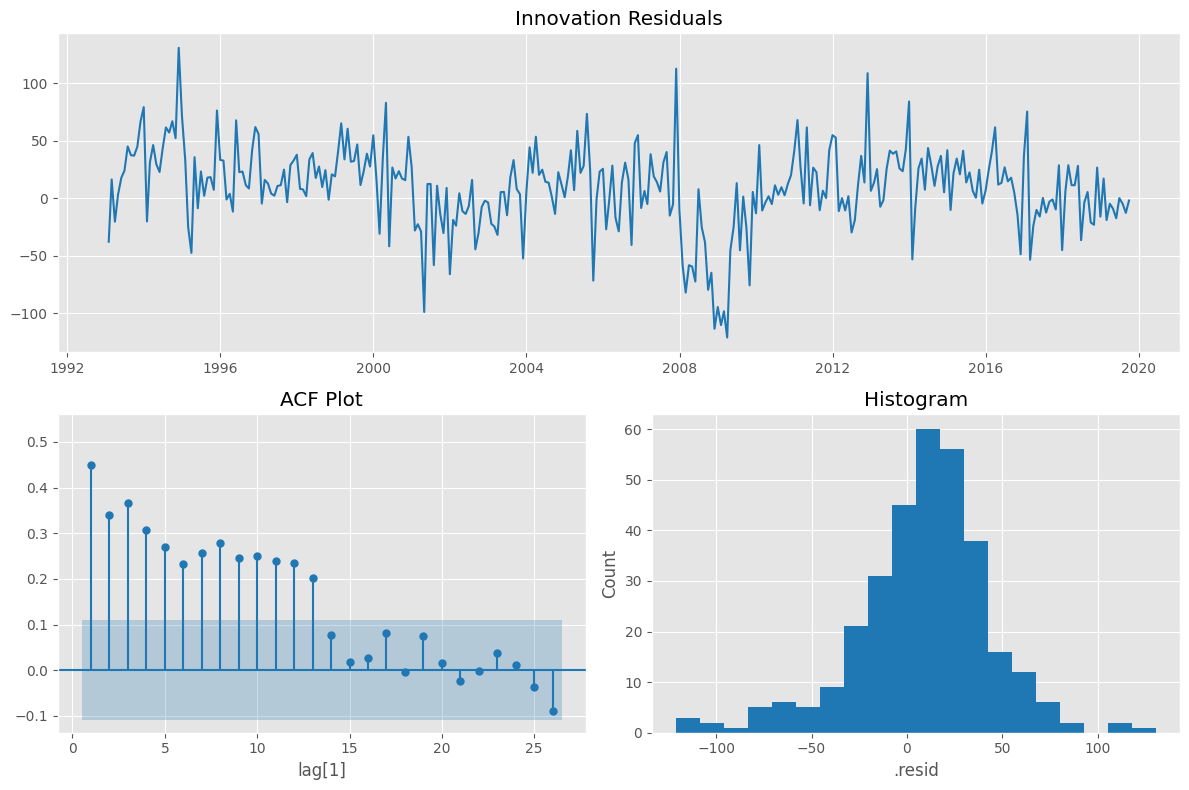

In [41]:
plot_diagnostics(train_df)

# [Evaluating point forecast accuracy](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-accuracy)

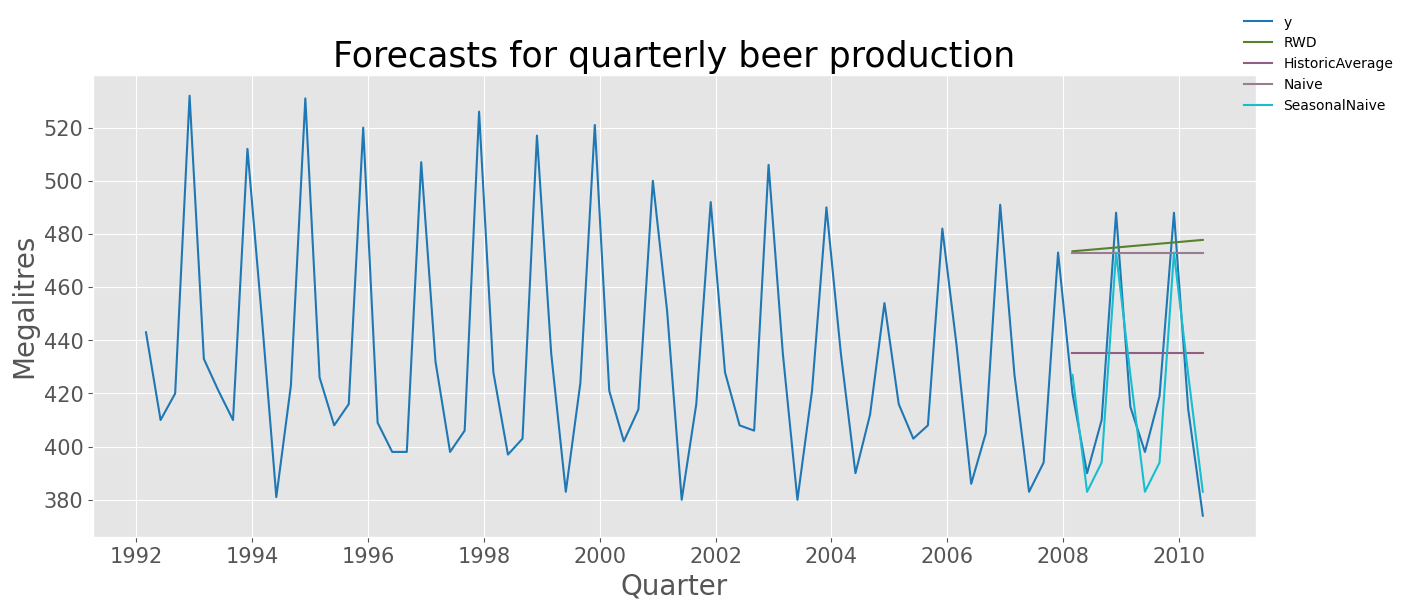

In [42]:
train_df = beers_df[beers_df["ds"].dt.year <= 2007].copy()
test_df = beers_df[beers_df["ds"].dt.year > 2007].copy()

mean_method = HistoricAverage()
naive_method = Naive()
drift_method = RandomWalkWithDrift()
seasonal_naive = SeasonalNaive(4)

sf = StatsForecast(
    models=[drift_method, mean_method, naive_method, seasonal_naive],
    freq=pd.tseries.frequencies.to_offset("QS-MAR"),
)
preds = sf.forecast(df=train_df, h=10)

plot_series(
    beers_df,
    preds,
    xlabel="Quarter",
    ylabel="Megalitres",
    title="Forecasts for quarterly beer production",
    rm_legend=False,
)

In [43]:
preds = preds.merge(test_df, on=["unique_id", "ds"])
preds.head()

,unique_id,ds,RWD,HistoricAverage,Naive,SeasonalNaive,y
0,Beer,2008-03-01,473.476,435.375,473.0,427.0,420.0
1,Beer,2008-06-01,473.952,435.375,473.0,383.0,390.0
2,Beer,2008-09-01,474.429,435.375,473.0,394.0,410.0
3,Beer,2008-12-01,474.905,435.375,473.0,473.0,488.0
4,Beer,2009-03-01,475.381,435.375,473.0,427.0,415.0


In [44]:
evaluation = evaluate(
    preds, metrics=[rmse, mae, mape, partial(mase, seasonality=4)], train_df=train_df
)
evaluation.drop(["unique_id"], axis=1, inplace=True)
evaluation

,metric,RWD,HistoricAverage,Naive,SeasonalNaive
0,rmse,64.901,38.447,62.693,14.311
1,mae,58.876,34.825,57.400,13.400
2,mape,14.577,8.283,14.184,3.169
3,mase,4.117,2.435,4.014,0.937


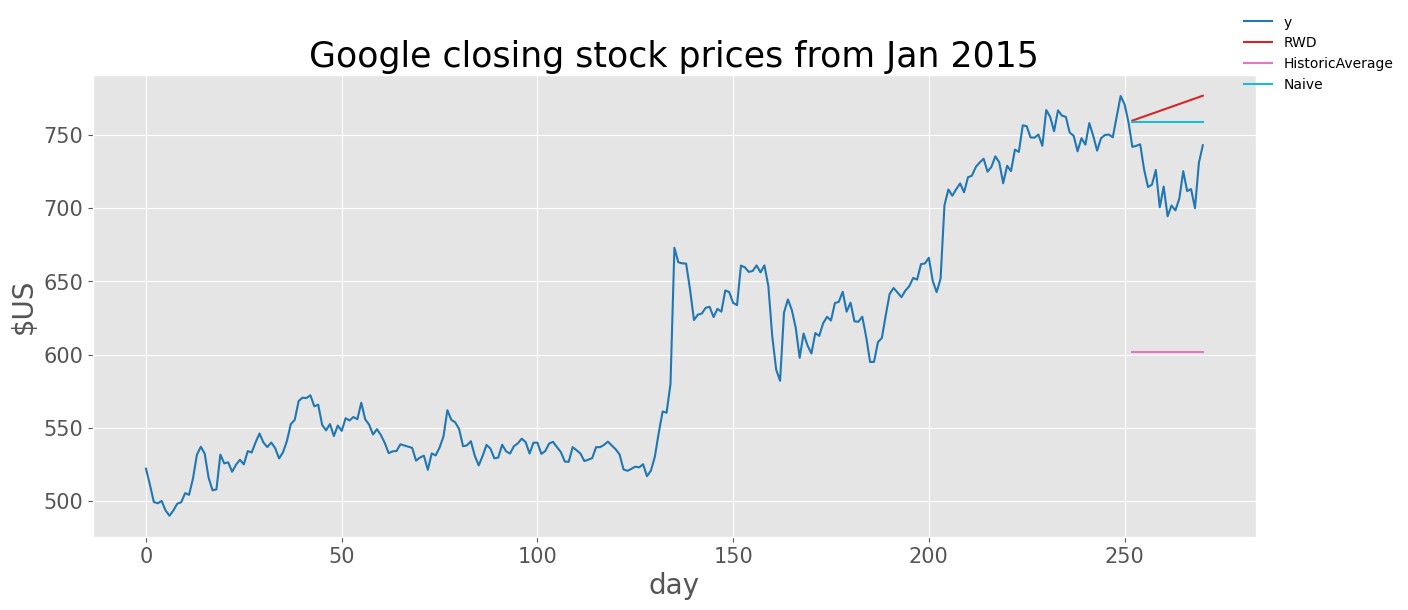

In [45]:
train_df = goog_df[goog_df["ds"].dt.year == 2015].copy()
test_df = goog_df[goog_df["ds"].dt.year == 2016].copy()
train_df["ds"] = np.arange(len(train_df["ds"]))
test_df["ds"] = np.arange(len(test_df["ds"]))

mean_method = HistoricAverage()
naive_method = Naive()
drift_method = RandomWalkWithDrift()

sf = StatsForecast(models=[drift_method, mean_method, naive_method], freq=1)
preds = sf.forecast(df=train_df, h=len(test_df))
preds["y"] = test_df["y"].values

plot_series(
    train_df,
    preds,
    xlabel="day",
    ylabel="$US",
    title="Google closing stock prices from Jan 2015",
    rm_legend=False,
)

In [46]:
evaluation = evaluate(
    preds, metrics=[rmse, mae, mape, partial(mase, seasonality=1)], train_df=train_df
)
evaluation.drop(["unique_id"], axis=1, inplace=True)
evaluation

,metric,RWD,HistoricAverage,Naive
0,rmse,53.070,118.032,43.432
1,mae,49.824,116.945,40.384
2,mape,6.992,16.235,5.673
3,mase,6.990,16.406,5.666


# [Evaluation distributional forecast accuracy](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-distaccuracy)

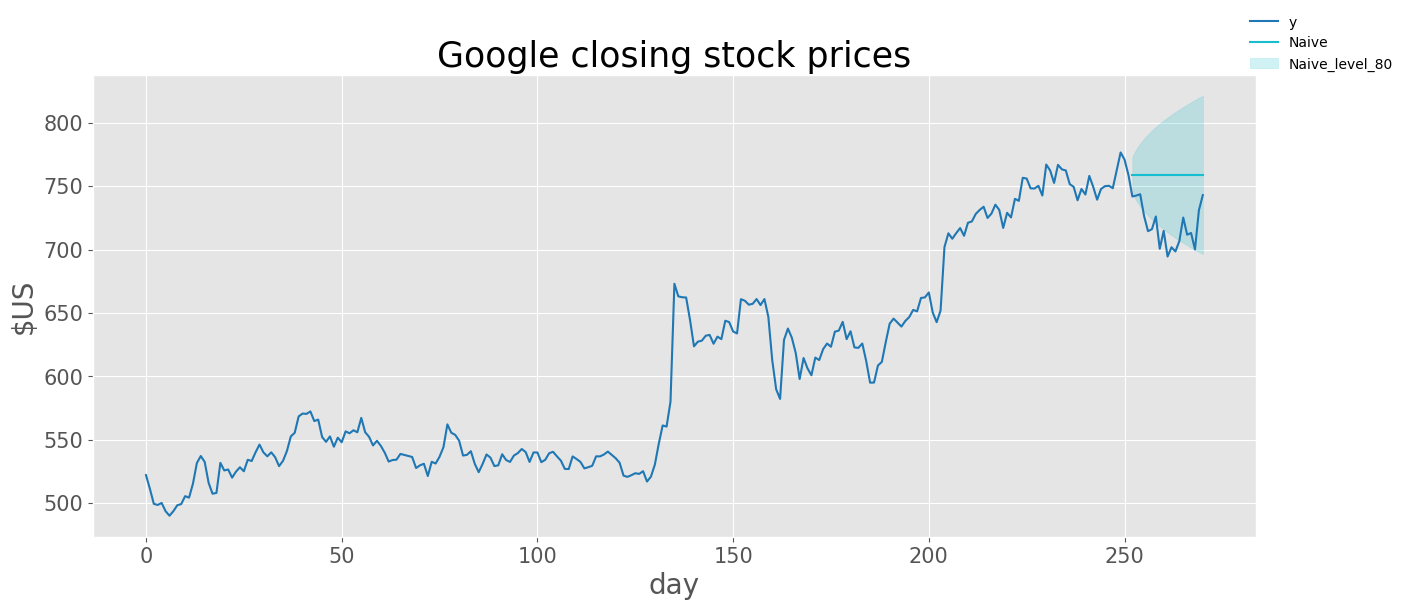

In [47]:
train_df = goog_df[goog_df["ds"].dt.year == 2015].copy()
test_df = goog_df[goog_df["ds"].dt.year == 2016].copy()
train_df["ds"] = np.arange(len(train_df["ds"]))
test_df["ds"] = np.arange(len(test_df["ds"]))

naive_model = Naive()

sf = StatsForecast(models=[naive_model], freq=1)
preds = sf.forecast(h=len(test_df), level=[80], df=train_df)
preds["y"] = test_df["y"].values

plot_series(
    train_df,
    preds,
    level=[80],
    xlabel="day",
    ylabel="$US",
    title="Google closing stock prices",
    rm_legend=False,
)

In [48]:
evaluation = evaluate(preds, metrics=[quantile_loss], level=[80])

methods = ["Naive"]
evaluation_transformed = pd.DataFrame(
    {
        "Method": methods,
        "Quantile loss (q=0.1)": evaluation[
            evaluation["metric"] == "quantile_loss_q0.1"
        ][methods]
        .iloc[0]
        .values,
        "Quantile loss (q=0.9)": evaluation[
            evaluation["metric"] == "quantile_loss_q0.9"
        ][methods]
        .iloc[0]
        .values,
    }
)
evaluation_transformed

,Method,Quantile loss (q=0.1),Quantile loss (q=0.9)
0,Naive,4.775,8.355


In [49]:
def compute_winkler_score(df, alpha=0.2):
    def winkler_score(row, alpha):
        L_t = row["Naive-lo-80"]
        U_t = row["Naive-hi-80"]
        y_t = row["y"]

        if L_t <= y_t <= U_t:
            return U_t - L_t
        elif y_t < L_t:
            return U_t - L_t + (2 / alpha) * (L_t - y_t)
        else:  # y_t > U_t
            return U_t - L_t + (2 / alpha) * (y_t - U_t)

    df["Winkler"] = df.apply(winkler_score, axis=1, alpha=alpha)
    winkler_score = df["Winkler"].iloc[0]

    data = [{"Method": "Naive", "Winkler score": winkler_score}]

    return pd.DataFrame(data=data, index=None)


winkler_score_df = compute_winkler_score(preds)
winkler_score_df

,Method,Winkler score
0,Naive,55.68


In [50]:
train_df = goog_df[goog_df["ds"].dt.year == 2015].copy()
test_df = goog_df[goog_df["ds"].dt.year == 2016].copy()

mean_method = HistoricAverage()
naive_method = Naive()
drift_method = RandomWalkWithDrift()

sf = StatsForecast(models=[drift_method, naive_method, mean_method], freq="B")
levels = list(np.arange(0, 100, 1 / 10))
preds = sf.forecast(df=train_df, h=len(test_df), level=levels)
preds["y"] = test_df["y"].values

models = ["RWD", "HistoricAverage", "Naive"]
crps_df = evaluate(
    df=preds,
    models=models,
    metrics=[mqloss],
    level=levels,
)
crps_df = crps_df[models].T.reset_index()
crps_df.columns = ["method", "CRPS"]
crps_df["CRPS"] *= 2
crps_df

,method,CRPS
0,RWD,33.557
1,HistoricAverage,76.789
2,Naive,26.500


In [51]:
naive_crps = crps_df.query("method == 'Naive'")["CRPS"].iloc[0]
crps_df["skill_score"] = crps_df.apply(
    lambda row: (
        (naive_crps - row["CRPS"]) / naive_crps if row["method"] != "Naive" else 0
    ),
    axis=1,
)
crps_df

,method,CRPS,skill_score
0,RWD,33.557,-0.266
1,HistoricAverage,76.789,-1.898
2,Naive,26.500,0.000


# [Time series cross-validation](https://otexts.com/fpppy/nbs/05-toolbox.html#sec-tscv)

In [52]:
goog_2015 = goog_df[goog_df["ds"].dt.year == 2015].copy()
drift_method = RandomWalkWithDrift()

sf = StatsForecast(models=[drift_method], freq="B")
cv_df = sf.cross_validation(h=1, df=goog_2015, step_size=1, test_size=249)

cv_df.head()

,unique_id,ds,cutoff,y,RWD
0,GOOG_Close,2015-01-07,2015-01-06,498.358,487.850
1,GOOG_Close,2015-01-08,2015-01-07,499.929,490.497
2,GOOG_Close,2015-01-09,2015-01-08,493.454,494.427
3,GOOG_Close,2015-01-12,2015-01-09,489.854,487.758
4,GOOG_Close,2015-01-13,2015-01-12,493.464,484.507


In [53]:
evaluation = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[rmse, mae, mape, partial(mase, seasonality=1)],
    train_df=goog_2015,
)
evaluation.drop(["unique_id"], axis=1, inplace=True)
evaluation

,metric,RWD
0,rmse,11.268
1,mae,7.261
2,mape,1.194
3,mase,1.019


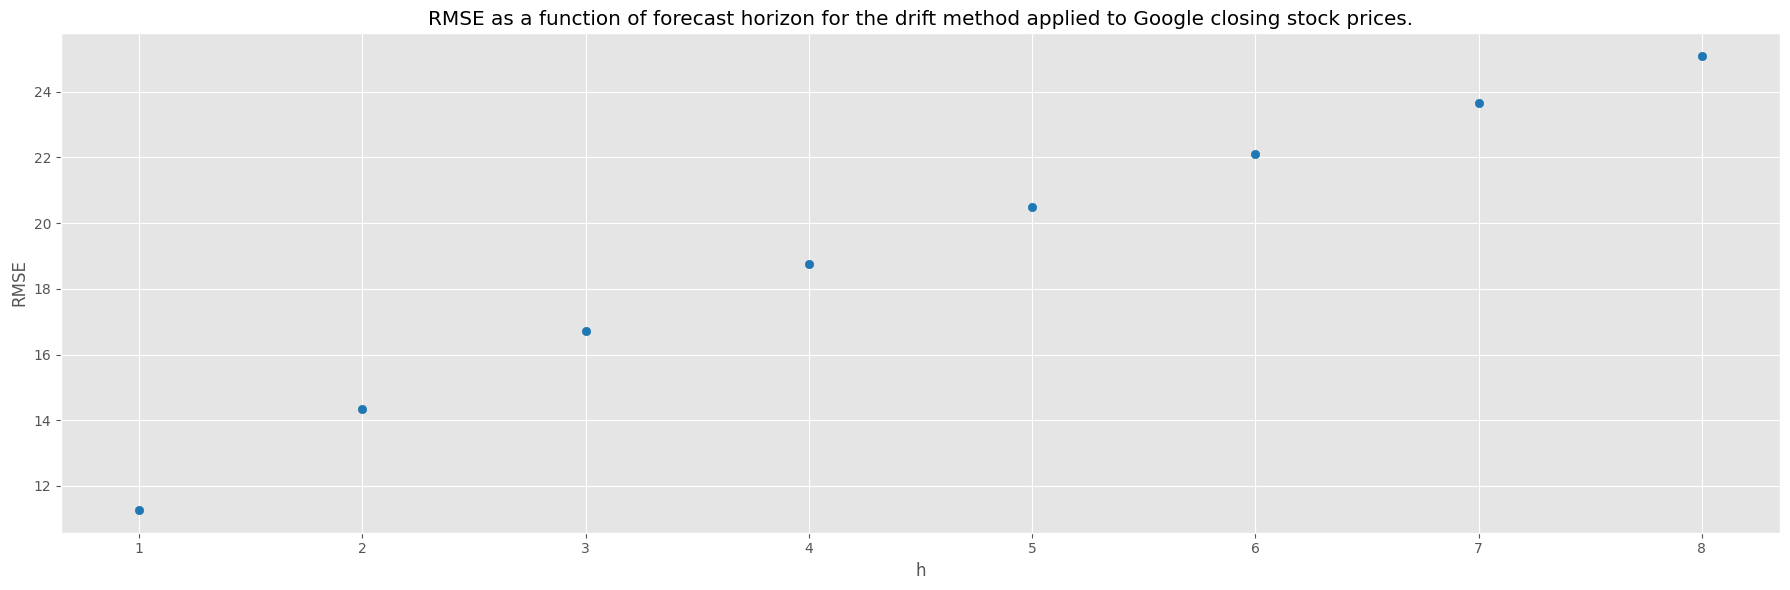

In [54]:
rmses = []
drift_model = RandomWalkWithDrift()

horizons = np.arange(1, 9)

for horizon in horizons:
    sf = StatsForecast(models=[drift_model], freq="B")
    cv_df = sf.cross_validation(h=horizon, df=goog_2015, step_size=1, test_size=249)
    cv_evaluation = evaluate(cv_df, metrics=[rmse], models=["RWD"])
    rmses.append(cv_evaluation["RWD"].iloc[0])

fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter(horizons, rmses)
ax.set_xlabel("h")
ax.set_ylabel("RMSE")
ax.set_title(
    "RMSE as a function of forecast horizon for the drift method applied to Google closing stock prices."
)
plt.tight_layout()

# Exercises